In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re

from sklearn.feature_extraction.text import CountVectorizer

import pymongo

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics


from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
    
from wordcloud import WordCloud,STOPWORDS 
from matplotlib import rcParams
from collections import Counter


# SETTING
plt.style.use('ggplot')
#display maximum column and rows
pd.options.display.max_columns = 999
pd.options.display.min_rows = 999
pd.options.display.max_colwidth = 500
stopword = STOPWORDS
stopword.add('im')
stopword.add('youre')


red = '#ef4b4b'
black = '#584b42'
green = '#a0cc78'
yellow_ = '#f6d365'
blue_ = '#49beb7'

#INIT


#METHODS
def sep():
    print(100*'-')

def connectMongoDB(dbname):
    client = pymongo.MongoClient('localhost', 27017)
    db = client[dbname]
    return db

dbname = 'clothing_fit'
db = connectMongoDB(dbname)

In [2]:
# update stopwords

stop_words = list(stopwords.words('english'))
stop_words.append('the')

# LEMMATIZER HELPER - karena proses lematisasi menggunakan wordnet lematizer, 
# dia butuh tag POS untuk parameternya

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
tag_map['N'] = wn.NOUN
print(wn.ADJ)
print(wn.VERB)
print(wn.ADV)

# LEMMATIZER
lmtzr = WordNetLemmatizer()


a
v
r


In [3]:
rent = list(db.rentCollection.find())
df_rent = pd.DataFrame(rent)

# MENGECEK NULL
df_rent.head(1)

,_id,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,sentiment_,height_cm,weight_kg,age_,review_date_,sentiment_summary,sentiment_text
0,5e2ab8ce9f84980caca61bf7,fit,420272,34d,2260466,137lbs,10.0,vacation,"An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016",positive,173.0,62.0,28.0,2016-04-20,positive,positive


In [4]:
print("Jumlah Transaksi : ", df_rent.shape[0])
print("Jumlah User Unik : ",df_rent.user_id.nunique())
print('Jumlah Item : ', df_rent.item_id.nunique())
x = df_rent.groupby(['item_id', 'size']).count()['_id']
xlen  = len(x.reset_index())
print('Jumlah Item x Size : ', xlen)

Jumlah Transaksi :  20027
Jumlah User Unik :  17352
Jumlah Item :  4022
Jumlah Item x Size :  10973


# Lanjutan Feedback Analysis
- salah satu score yang akan digunakan adalah rating, (handling null dahulu)
- akan dilakukan analisa berdasarkan feedback rating terlebih dahulu

In [5]:
df_rent[df_rent['rating'].isnull()][['fit','sentiment_', 'review_summary']]

# karena 3 data null mendapat feedback positif (fit == fit dan sentiment == positif) -> sempurna 

,fit,sentiment_,review_summary


In [6]:
print(df_rent.rating.mode())
print(df_rent.rating.mean())
print(df_rent.rating.quantile(0.5))

0    10.0
dtype: float64
9.091925900034953
10.0


In [7]:
# mereplace null dengan angka 10 -> modus dan median + analisa feedback yang positif

df_rent.rating = df_rent.rating.fillna(10)
print("banyak data : ", len(df_rent))
sep()
print("angka null di rating :")
df_rent['rating'].isnull().sum()

banyak data :  20027
----------------------------------------------------------------------------------------------------
angka null di rating :


0

In [8]:
df_rent.head(1)

,_id,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,sentiment_,height_cm,weight_kg,age_,review_date_,sentiment_summary,sentiment_text
0,5e2ab8ce9f84980caca61bf7,fit,420272,34d,2260466,137lbs,10.0,vacation,"An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016",positive,173.0,62.0,28.0,2016-04-20,positive,positive


In [9]:
df_low = df_rent[df_rent['rating']<=6]
print("banyak transaksi di bawah 6 : ", df_low.shape)
user_low = df_low.user_id.unique()
print("banyak user me-rating low",len(user_low))

banyak transaksi di bawah 6 :  (1495, 23)
banyak user me-rating low 1453


### Melihat berapa kali user pernah menyewa pakaian dan Bagaimana Rating Feedback yang diberikan

In [10]:
df_rent.groupby('user_id').count()['rented for'].value_counts()

1     15603
2      1310
3       254
4       101
5        37
6        22
8         8
9         4
7         3
11        2
10        2
47        1
32        1
22        1
29        1
12        1
16        1
Name: rented for, dtype: int64

(17352, 1)
(17,)
(17,)


c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


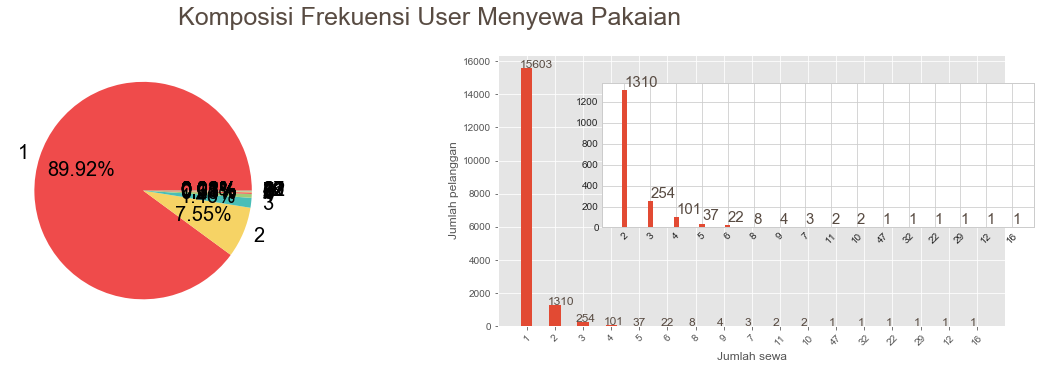

In [11]:
user_df = df_rent.groupby('user_id').count()[['rented for']]

print(user_df.shape)
kali_sewa = user_df['rented for'].value_counts()
print(kali_sewa.shape)
kali_sewa

sums = pd.DataFrame(kali_sewa)
sums = sums

fig = plt.figure(figsize=(20,5))

plt.suptitle('Komposisi Frekuensi User Menyewa Pakaian', fontsize='25', 
             color=black, 
            va='center')

##### PIE
plt.style.use('ggplot')
plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,yellow_,blue_, green], textprops={'fontsize': 20})
#  = ax.pie(frac, colors=colors, labels=labels, autopct='%1.1f%%')
# texts[0].set_fontsize(18)

#### BAR
plt.subplot(122)
heights = sums['rented for']
print(heights.shape)
tick_labels = sums['rented for'].index.tolist()

# ax = fig.add_axes([0,0,0,0])
plt.bar(range(0, 34, 2), heights)
for i, v in enumerate(heights):
    plt.text(i*2 - 0.5,v+2 , str(v), color=black, fontsize='12')
plt.xlabel('Jumlah sewa')
plt.ylabel('Jumlah pelanggan')
plt.xticks(range(0,34,2),tick_labels , rotation=45)
# print(df_kata.index)
lcs, labels = plt.xticks()
# print(lcs)

plt.style.use('seaborn-whitegrid')
# ZOOM IN perbandingan sentiment negatif dan netral
ax = fig.add_axes([0.62,0.4,0.3,0.4])
plt.bar(range(0, 64, 4), heights[1:])
# plt.bar(tick_labels[1:],heights[1:], color=[red,black,])

for i, v in enumerate(heights[1:]):
    plt.text(i*4,v + 30 , str(v), color=black, fontsize='15')

plt.xticks(range(0,64,4),tick_labels[1:] , rotation=45)
plt.show()

## Hampir 90% user hanya melakukan 1x transaksi dalam data ini (15603 unique users)
#### 7.5% user melakukan 2x transaksi
#### frekuensi tertinggi mencapai 47 kali sewa

	Penting bagi perusahaan untuk menjaga engagement customer yang sudah setia dengan perusahaan. Ada user yang mencapai 16 kali sewa, 22 kali sewa, 32 kali sewa, hingga 46 kali sewa. Namun dari data yang ada saat ini sebanyak 90% customer hanya/ baru menyewa pakaian sebanyak 1 kali. 7.5 % customer pernah menyewa sebanyak 2x. dan, 2.5% sisanya mencapai 3 kali sewa hingga 46 kali sewa.

<hr>

berdasarkan data, komposisi terbanyak saat ini adalah customer baru, yaitu hanya pernah menyewa sebanyak 1 kali.
Oleh karena itu, __perlu inspeksi lebih lanjut bagaimana feedback dari customer baru yang hampir mencapai 90% dari semua data ini.__

- Bagaimana feedback user baru setelah bertransaksi di RTR ?

In [12]:
new_user_df = user_df[user_df['rented for'] <=2 ]
new_user_df = new_user_df.reset_index()

new_user_id = list(new_user_df['user_id'])
df_rent_newuser = df_rent[df_rent['user_id'].isin(new_user_id)]
print(df_rent_newuser.shape) # ada 18223 transaksi dari user baru 

df_rent_newuser['rating'].value_counts()



(18223, 23)


10.0    11783
8.0      5107
6.0       962
4.0       289
2.0        82
Name: rating, dtype: int64

In [13]:
new_user_df = user_df[user_df['rented for'] <2 ]
new_user_df = new_user_df.reset_index()

new_user_id = list(new_user_df['user_id'])
df_rent_newuser = df_rent[df_rent['user_id'].isin(new_user_id)]
print(df_rent_newuser.shape) # ada 18223 transaksi dari user baru 

df_rent_newuser['rating'].value_counts()

(15603, 23)


10.0    10140
8.0      4331
6.0       815
4.0       246
2.0        71
Name: rating, dtype: int64

In [14]:
df_rent_newuser_low = df_rent_newuser[df_rent_newuser['rating']<=6]
print(df_rent_newuser_low.shape)

(1132, 23)


(15603, 23)
(3,)


c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


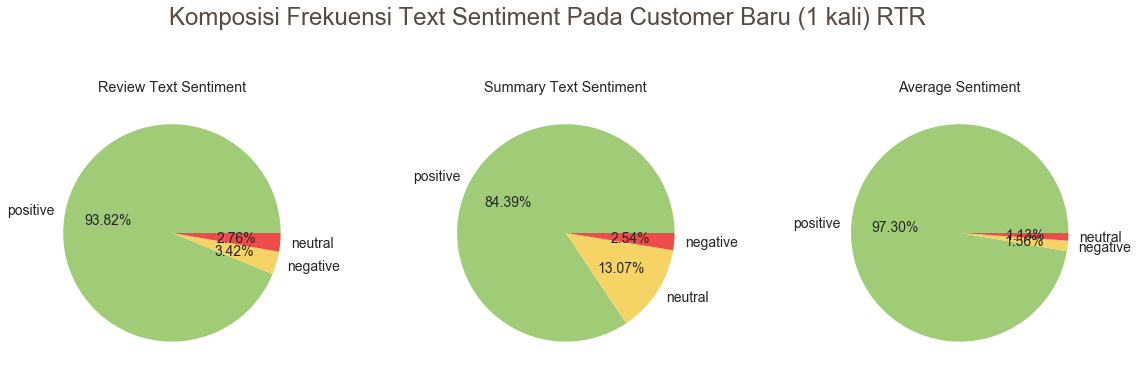

In [15]:
print(df_rent_newuser.shape)
rating_new_user = df_rent_newuser['sentiment_text'].value_counts()
print(rating_new_user.shape)
rating_new_user

sums = pd.DataFrame(rating_new_user)
sums = sums

fig = plt.figure(figsize=(20,5))

##### PIE
plt.style.use('ggplot')
plt.subplot(131)
plt.suptitle('Komposisi Frekuensi Text Sentiment Pada Customer Baru (1 kali) RTR', fontsize='24', 
             color=black, 
            va='center',
            y=1.1)
plt.title('Review Text Sentiment')
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[green,yellow_, red], textprops={'fontsize': 14})


rating_new_user = df_rent_newuser['sentiment_summary'].value_counts()
sums = pd.DataFrame(rating_new_user)
sums = sums

##### PIE
plt.style.use('ggplot')
plt.subplot(132)
plt.title('Summary Text Sentiment', y=1)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[green,yellow_, red], textprops={'fontsize': 14})


rating_new_user = df_rent_newuser['sentiment_'].value_counts()
sums = pd.DataFrame(rating_new_user)
sums = sums

##### PIE
plt.style.use('ggplot')
plt.subplot(133)
plt.title('Average Sentiment')
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[green,yellow_, red], textprops={'fontsize': 14})


plt.show()

(15603, 23)
(5,)
(5,)


c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


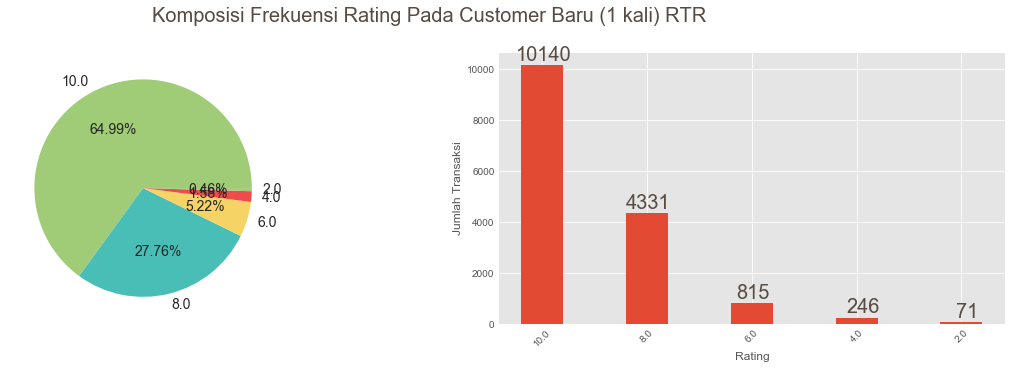

In [16]:
print(df_rent_newuser.shape)
rating_new_user = df_rent_newuser['rating'].value_counts()
print(rating_new_user.shape)
rating_new_user

sums = pd.DataFrame(rating_new_user)
sums = sums

fig = plt.figure(figsize=(20,5))

##### PIE
plt.style.use('ggplot')
plt.subplot(121)
plt.suptitle('Komposisi Frekuensi Rating Pada Customer Baru (1 kali) RTR', fontsize='20', 
             color=black, 
            va='center')
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[green, blue_,yellow_, red], textprops={'fontsize': 14})

#### BAR
plt.subplot(122)
heights = sums['rating']
print(heights.shape)
tick_labels = sums['rating'].index.tolist()

# ax = fig.add_axes([0,0,0,0])
plt.bar(range(0, 10, 2), heights)
for i, v in enumerate(heights):
    plt.text(i*2.1 - 0.5,v+200 , str(v), color=black, fontsize='20')
plt.xlabel('Rating')
plt.ylabel('Jumlah Transaksi')
plt.xticks(range(0,10,2),tick_labels , rotation=45)
# print(df_kata.index)
lcs, labels = plt.xticks()
# print(lcs)

plt.show()

In [17]:
print(df_rent_newuser.shape)
rating_new_user = df_rent_newuser['rating'].value_counts()
print(rating_new_user.shape)

rating_new_user = pd.DataFrame(rating_new_user)
rating_new_user.reset_index(inplace=True)
rating_new_user1 = rating_new_user.iloc[:2]
rating_new_user1.sum
# rating_new_user.groupby('index').resample(3).sum()
# bins = pd.IntervalIndex.from_tuples([(0, 6), (7, 10)])
# pd.cut(rating_new_user, bins)

# sums = pd.DataFrame(rating_new_user)
# sums = sums

# fig = plt.figure(figsize=(20,5))

# ##### PIE
# plt.style.use('ggplot')
# plt.subplot(121)
# plt.suptitle('Komposisi Frekuensi Rating Pada Customer Baru (1 kali) RTR', fontsize='20', 
#              color=black, 
#             va='center')
# plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[green, blue_,yellow_, red], textprops={'fontsize': 14})


(15603, 23)
(5,)


<bound method DataFrame.sum of    index  rating
0   10.0   10140
1    8.0    4331>

(15603, 23)
(3,)
(3,)


c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


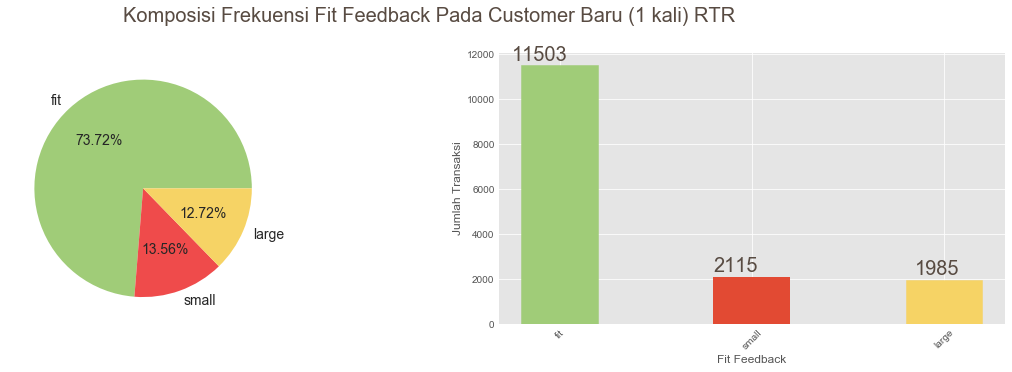

In [18]:
print(df_rent_newuser.shape)
rating_new_user = df_rent_newuser['fit'].value_counts()
print(rating_new_user.shape)
rating_new_user

sums = pd.DataFrame(rating_new_user)
sums = sums

fig = plt.figure(figsize=(20,5))

##### PIE
plt.style.use('ggplot')
plt.subplot(121)
plt.suptitle('Komposisi Frekuensi Fit Feedback Pada Customer Baru (1 kali) RTR', fontsize='20', 
             color=black, 
            va='center')
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[green, red, yellow_], textprops={'fontsize': 14})

#### BAR
plt.subplot(122)
heights = sums['fit']
print(heights.shape)
tick_labels = sums['fit'].index.tolist()

# ax = fig.add_axes([0,0,0,0])
barlist = plt.bar(range(0, 6, 2), heights)
barlist[0].set_color(green)
barlist[2].set_color(yellow_)
for i, v in enumerate(heights):
    plt.text(i*2.1 - 0.5,v+200 , str(v), color=black, fontsize='20')
plt.xlabel('Fit Feedback')
plt.ylabel('Jumlah Transaksi')
plt.xticks(range(0,6,2),tick_labels , rotation=45)
# print(df_kata.index)
lcs, labels = plt.xticks()
# print(lcs)

plt.show()

c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


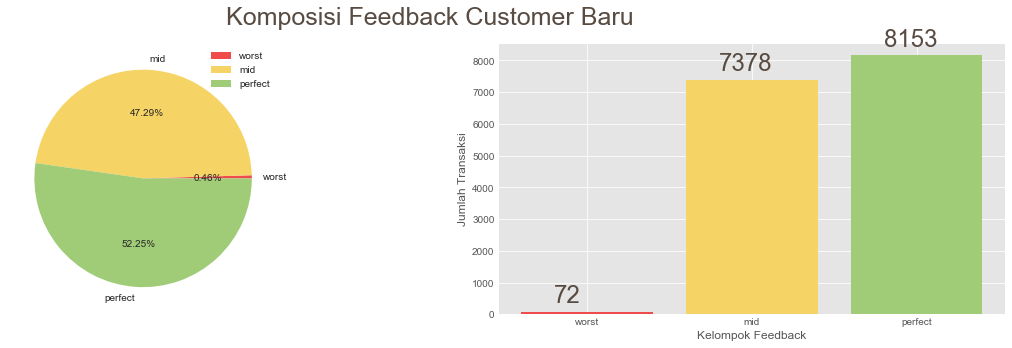

In [19]:
df_perfect = df_rent_newuser[df_rent_newuser['rating']==10][df_rent_newuser['fit']=='fit'][df_rent_newuser['sentiment_']=='positive']
df_perfect.shape

df_worst = df_rent_newuser[df_rent_newuser['rating']<6][df_rent_newuser['fit']!='fit'][df_rent_newuser['sentiment_']!='positive']
df_worst.shape

mid = df_rent_newuser.shape[0]-df_perfect.shape[0]-df_worst.shape[0]
top = df_perfect.shape[0]
low = df_worst.shape[0]

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Feedback Customer Baru', fontsize='25', color=black)

plt.subplot(121)
plt.pie([low, mid, top], labels=['worst', 'mid', 'perfect'], autopct='%1.2f%%',colors=[red,yellow_,green])

plt.legend()

plt.subplot(122)
index = ['worst', 'mid', 'perfect']
count = [low, mid, top]

plt.bar(index[:],count[:], color=[red,yellow_,green])
for i, v in enumerate(count[:]):
    plt.text((i-0.2),v+300 , str(v), color=black, fontsize='24')
plt.xlabel('Kelompok Feedback')
plt.ylabel('Jumlah Transaksi')

plt.show()

In [20]:
df_worst['review_text']

# PREPROCESSING TEXT
dokumen_input =  df_worst['review_text']
# neg.loc[:,0]
# selecting kalimat

print("banyak dokumen input : ", len(dokumen_input))

hasil_preprocessing = []
for i in dokumen_input:
    text = re.sub(r'[^\w\s]','',i)            # PUNCTUATION REMOVAL
    text = text.lower()                       # LOWERCASE TRANSFORMATION
    word_tokens = word_tokenize(text)         # TOKENIZING # memecah kalimat jadi kata
    
    filtered_sentence = []
    for token, tag in pos_tag(word_tokens):           # eksekusi sesuatu pada tiap token kata
        if token not in stop_words:
            if token not in stopword:           # STOPWORD REMOVAL
                lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
    #             print(token, "=>", lemma)
                filtered_sentence.append(lemma)
#     print(filtered_sentence)
    text = (' ').join(filtered_sentence)      # REFORM SENTENCE
    hasil_preprocessing.append(text)

print("banyak dokumen hasil :", len(hasil_preprocessing))

banyak dokumen input :  72
banyak dokumen hasil : 72


In [21]:
# MENDAPATKAN SEMUA TOKEN

dokumen_input = hasil_preprocessing
dokumen_input

all_tokens = []
for i in dokumen_input:
    word_tokens = word_tokenize(i)
    all_tokens.extend(word_tokens)
all_tokens[:26]

['way',
 'big',
 'odd',
 'fit',
 'couldnt',
 'wear',
 'run',
 'small',
 'hip',
 'dress',
 'make',
 'young',
 'girl',
 'look',
 'little',
 'bit',
 'old',
 'completely',
 'unexpected',
 'finally',
 'fit',
 'size',
 'big',
 'usually',
 'dress',
 'turn']

In [22]:
# HITUNG FREKUENSI MASING2 KATA
print("semua kata dalam token : ", len(all_tokens))
dokumen_input = all_tokens

counts = Counter(dokumen_input)
kata = counts.keys()
count_kata = counts.values()
df_x = pd.DataFrame(count_kata, index = kata)
df_x = df_x.sort_values(0,ascending=False)

kata = df_x.index
count_kata = df_x[0].tolist()

semua kata dalam token :  1395


In [23]:
dokumen_input = kata

benda = []
sifat = []
kerja = []
lain2 = []
all_tag = []
for token, tag in pos_tag(dokumen_input):
#     print(token," =>", tag)
    all_tag.append(tag)
    if tag[0] == 'N':
        benda.append(token)
    elif tag[0] == 'J':
        sifat.append(token)
    elif tag[0] == 'V':
        kerja.append(token)
    else :
        lain2.append(token)
        
df_kata_v_neg_baru = df_x.copy()
df_kata_v_neg_baru['POS'] = all_tag

print("jumlah semua kata unik : ", len(df_kata_v_neg_baru))
print("jumlah kata benda : ", len(benda))
print("jumlah kata sifat : ", len(sifat))
print("jumlah kata kerja : ", len(kerja))
print("jumlah kata lain2 : ", len(lain2))
df_kata_v_neg_baru.head(25)

jumlah semua kata unik :  516
jumlah kata benda :  218
jumlah kata sifat :  137
jumlah kata kerja :  53
jumlah kata lain2 :  108


,0,POS
dress,78,NN
wear,49,JJ
fit,32,JJ
look,31,NN
size,27,NN
didnt,20,JJ
way,17,NN
short,17,JJ
big,17,JJ
long,15,RB


c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.


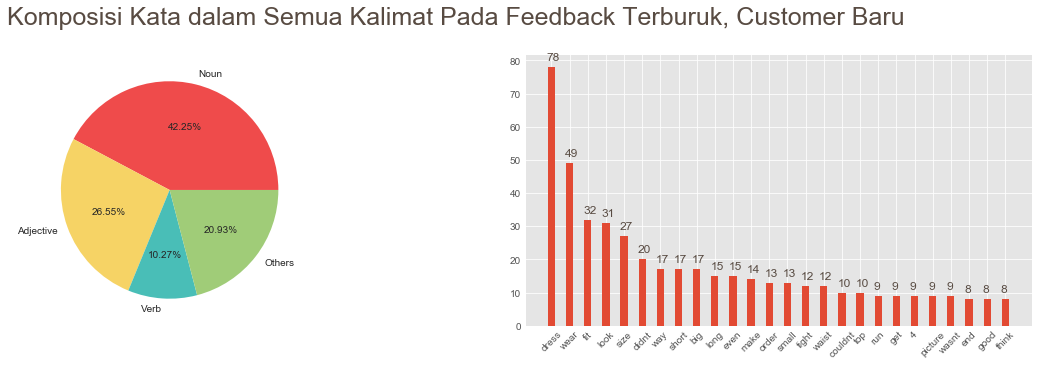

In [24]:
sums = pd.DataFrame([len(benda), len(sifat), len(kerja), len(lain2)] , index=['Noun', 'Adjective', 'Verb', 'Others'])
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Kata dalam Semua Kalimat Pada Feedback Terburuk, Customer Baru', fontsize='25', 
             color=black, 
            va='center')

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,yellow_,blue_, green] )

plt.subplot(122)
heights = df_kata_v_neg_baru[0][0:26]
tick_labels = df_kata_v_neg_baru.index.tolist()[0:26]

plt.bar(range(0, 52, 2), heights)
for i, v in enumerate(heights):
    plt.text(i*2 - 0.5,v+2 , str(v), color=black, fontsize='12')

plt.xticks(range(0,52,2),tick_labels , rotation=45)
# print(df_kata.index)
lcs, labels = plt.xticks()
# print(lcs)
plt.show()

======== MEMBUAT WORDCLOUD REVIEW VERY NEGATIF=========


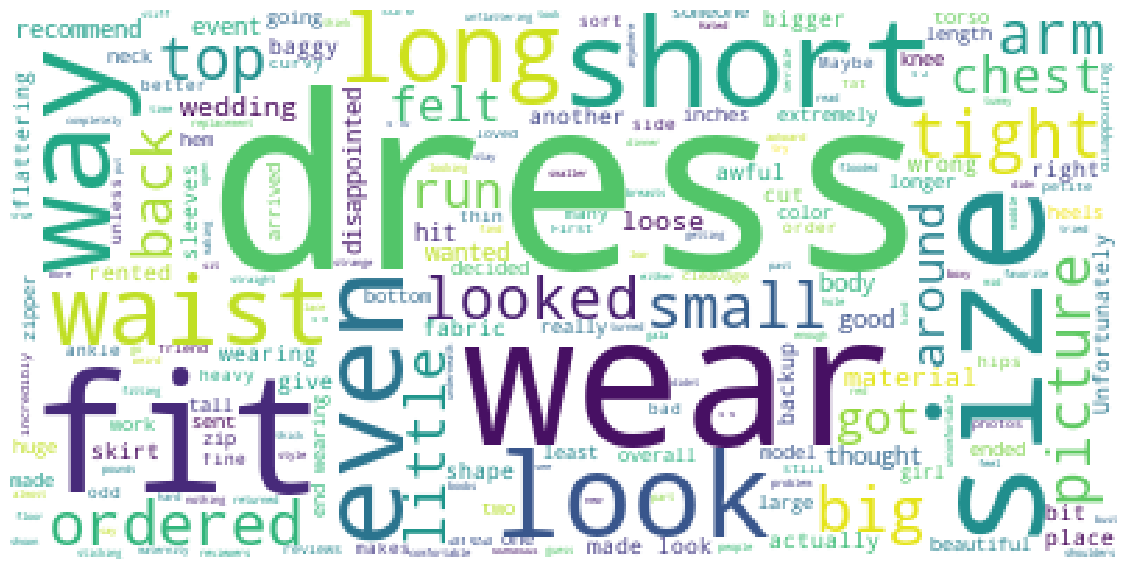

In [25]:

print("======== MEMBUAT WORDCLOUD REVIEW VERY NEGATIF=========")
#print(semua)

semua = ''.join(df_worst.loc[:, 'review_text'])
wordcloud = WordCloud(stopwords = stopword, background_color="white").generate(semua)
rcParams['figure.figsize'] = 20,20
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

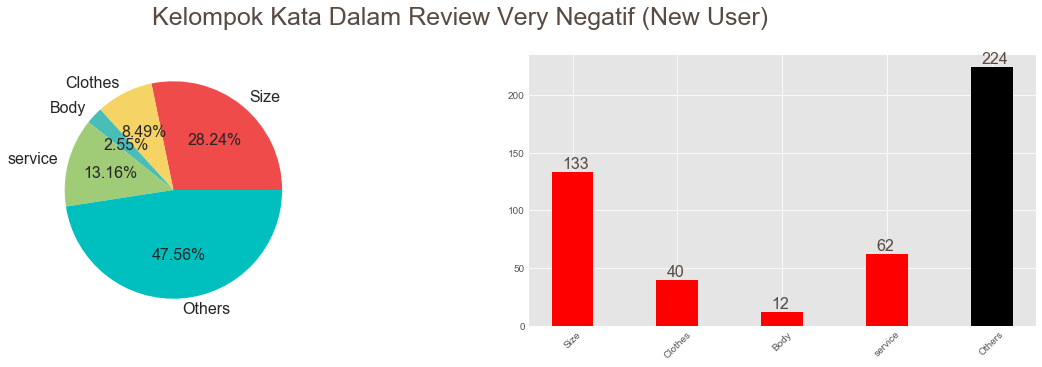

In [28]:
heights = df_kata_v_neg_baru[0][0:26]
tick_labels = df_kata_v_neg_baru.index.tolist()[0:26]
tick_labels

size_term = ['size', 'fit', 'small', 'little', 'short', 'long', 'large', 'tight', 'low','big']
cloth_term = ['look', 'fabric', 'material', 'bra', 'cut', 'loose', 'zipper', 'picture']
body_term = ['waist', 'back', 'hip']
service_term = ['wear', 'rent' , 'order']
general = ['dress','didnt', 'work', 'bit', 'way', 'wasnt', 
           'even', 'end', 'one', 'bit', 'area', 'love', 'really',
           'make','run', 'get','4', 'good', 'and', 'think']


counts_term = [0,0,0,0, 0]
for i in tick_labels:
    n = heights[tick_labels.index(i)]
    if i in size_term:
        counts_term[0]+= n
    elif i in cloth_term:
        counts_term[1]+=n
    elif i in body_term:
        counts_term[2]+= n
    elif i in service_term:
        counts_term[3]+= n
    else:
        counts_term[4]+=n
            
# print(counts_term)

fig = plt.figure(figsize=(20,5))
plt.suptitle("Kelompok Kata Dalam Review Very Negatif (New User)", fontsize='25', 
             color=black, 
            va='center')

plt.subplot(121)
plt.pie(counts_term, labels=['Size', 'Clothes', 'Body', 'service',"Others"], 
        autopct='%1.2f%%',colors=[red,yellow_,blue_, green,'c'], textprops={'fontsize': 16} )


plt.subplot(122)
tick_labels = ['Size', 'Clothes', 'Body', 'service',"Others"]
plt.bar(range(0, 10, 2), counts_term, color=['r', 'r','r', 'r','k'])
rcParams['axes.titlepad'] = 5 

for i, v in enumerate(counts_term):
    plt.text(i*2+.3 - 0.5,v+3 , str(v), color=black, fontsize='16')
plt.xticks(range(0,10,2),tick_labels, rotation=45)


plt.show()

<hr>

# Popularity Recommender System

1. Menentukan variabel yang diukur (rating) -> menunjukkan bahwa pakaian sudah pernah disewa dan diberi feedback, range(0 - 10)
2. Meghitung skor weighted rating pada tiap item, berdasarkan feeback yang diperoleh dari customer. 
3. Sort, item dengan hasil rating tertinggi akan menjadi top rekomendasi.

<hr>

## Weighted Rating 
### $$ WR = (\frac {v}{v+m} . R)+(\frac {m}{v+m}.C) $$


#### - R = rata-rata rating tiap item
#### - v = jumlah vote untuk masing2 item
#### - C = mean vote dari semua data yang tersedia
#### - m = minimum votes yang memenuhi syarat (treshold : persentil ke-90)


<hr>

# Mencari rata2 rating dari tiap Item Pakaian

### Item Pakaian dihitung berdasarkan id item x size, karena masing-masing ukuran akan merepresentasikan kecocokan customer yang berbeda

In [ ]:
df_metadata = df_rent.groupby(['item_id','size']).mean()
df_metadata[['rating']].head(10)

## Menghitung Jumlah Transaksi pada tiap Items

In [ ]:
df_metadata['vote_count'] = df_rent.groupby(['item_id', 'size']).count()['rating']
df_metadata.describe()
# df_metadata.shape

In [ ]:
# Calculate C (mean vote dari semua data yang tersedia)

C = df_metadata['rating'].mean()
print(C)

The average rating of items on RTR is around 9, on a scale of 10.

In [ ]:
# Calculate the minimum number of votes required to be in the chart, m 
## persentil ke 90 dari angka vote keseluruhan data

m = df_metadata['vote_count'].quantile(0.90)
print(m)

Next, we can filter the clothes item that qualify for the chart, based on their vote counts:

## Memfilter item2 yang memiliki lebih dari angka mininum vote. dalam kasus ini persentil ke 90 = m = 3

In [ ]:
print("sebelum filter : ", df_metadata.shape)

q_clothes = df_metadata.copy().loc[df_metadata['vote_count'] >= m]
print("setelah filter : ", q_clothes.shape)

- ada 1726 item yang relevan untuk diajukan sebagai rekomendasi karena kepopuleran item.
- semua item dalam 1726 data ini sudah memenuhi batas sewa minimum untuk menjadi populer.
- item dianggap populer jika telah mencapai batas minimum kepopuleran yang didapat dari angka desil 9 dari data vote yang ada

In [ ]:
q_clothes.head()

In [ ]:
# Function that computes the weighted rating of each clothes

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['rating']
    
    # Calculation based on the IMDB formula
    # jumlah Nvote * rating
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`

q_clothes['score'] = q_clothes.apply(weighted_rating, axis=1)
q_clothes.head()
# q_clothes.shape
# q_clothes

In [ ]:
#Sort clothes-items based on score calculated above

q_clothes = q_clothes.sort_values('score', ascending=False)
q_clothes.tail()

ini adalah scorre rating terrendah dari 410 data

# Rekomendasi Berdasarkan Rating dan Popularity

In [ ]:
q_clothes.shape

In [ ]:
def getPopRecom(num):
    return q_clothes.head(num)

getPopRecom(10)

done

<hr>

<hr>

## Menyeleksi transaksi dg item yang mencapai persentil 90 ke atas

In [ ]:
df_rent.columns.tolist()

In [ ]:
# membuat df baru untuk memuat transaksi yang memuat item2 terfilter (persentil ke 90)

df_reco = pd.DataFrame(columns=df_rent.columns)

df_reco

In [ ]:
indexRecoitems = q_clothes.index
# print(indexRecoitems)
indexRecoitems = (list(indexRecoitems))
indexRecoitems = list(map(lambda x : x[0] + ", "+ str(x[1]) , indexRecoitems))
indexRecoitems

In [ ]:
df_rent['item_id_size'] = df_rent['item_id'] + ', ' + df_rent['size'].astype('str')
df_rent.head(1)

In [ ]:
# memasukkan transaksi2 yang melibatkan item2 410 rekomendasi di dalam filter

for i in indexRecoitems:
#     print(df_rent[df_rent['item_id']==i])
    print(i)
    rekoi = pd.DataFrame(df_rent[df_rent['item_id_size']==i])
    print(len(rekoi))
    df_reco = pd.concat([df_reco,rekoi], axis=0)
    
df_reco.shape

In [ ]:
# df_reco ini adalah df yang berisi 9683 data. yaitu data yang terdapat 410 item rekomendasi populer

df_reco.shape

# ada 8652 transaksi yang telah melibatkan 1726 recommended popular items

## Eksport DataFrame yang Memuat 1726 Items (persentil ke-90 ke atas)

In [ ]:
# df_reco.to_csv('df_reco_410_item.csv')
df_reco.to_csv('df_reco_1726_item.csv')

In [ ]:
df_reco = pd.read_csv('df_reco_1726_item.csv')

print(df_reco.shape)
df_reco.isnull().sum()

In [ ]:
# sekilas mengetahui kondisi data body type awal 

print("jumlah unik value : ",df_rent['body type'].nunique())
# ada 7, nan tidak dihiitung guys
print(df_rent['body type'].isnull().sum())
df_rent['body type'].unique().tolist()


# Body Type

In [ ]:
print("jumlah tanpa nan : ",df_reco.groupby('body type').count()[['item_id']].sum()[0])
# ada 589 nan body type di dalam data
print('jumlah nan : ',df_reco['body type'].isnull().sum())
df_reco.groupby('body type').count()[['item_id']]

In [ ]:
# df_reco_bodyshape  merupakan df_reco yang sudah siap untuk dipakai untuk rekomendasi berdasarkan bodyshape

df_reco_bodyshape = df_reco.dropna(subset=['body type'])

print("banyak data : ", len(df_reco_bodyshape))
df_reco_bodyshape.isnull().sum()

### saat ini ada df_reco_bodyshape -> 9094 data yang siap dijadikan acuan terhadap rekomendasi berdasarkan jenis bentuk badan

<hr>
<hr>

# RENTED FOR

In [ ]:
print("jumlah value unik : ", df_rent['rented for'].nunique())
sep()
print('jumlah mula-mula : ', len(df_reco))
print("jumlah tanpa nan : ",df_reco.groupby('rented for').count()[['item_id']].sum()[0])
print("ada nan : ", df_reco['rented for'].isnull().sum() )
df_reco.groupby('rented for').count()[['item_id']]

In [ ]:
# mengilangkan nan

df_reco_rentedfor = df_reco.dropna(subset=['rented for'])
df_reco_rentedfor.shape

## df_reco_rentedfor => 9682 data yang siap dijadikan acuan terhadap rekomendasi berdasarkan keperluan menyewa

<hr>
<hr>

# Rented For X Body Type

In [ ]:
print('jumlah mula-mula : ', len(df_reco_bodyshape))
print("jumlah tanpa nan : ",df_reco_bodyshape.groupby('rented for').count()[['item_id']].sum()[0])
print("ada nan : ", df_reco_bodyshape['rented for'].isnull().sum() )


df_reco_bodyshape.groupby('rented for').count()[['item_id']]

# Body Shape x Rented For

In [ ]:
print('jumlah mula-mula : ', len(df_reco_rentedfor))
print("jumlah tanpa nan : ",df_reco_rentedfor.groupby('body type').count()[['item_id']].sum()[0])
print("ada nan : ", df_reco_rentedfor['body type'].isnull().sum() )


df_reco_rentedfor.groupby('body type').count()[['item_id']]

In [ ]:
# ternyata dibolakbalik sama saja
df_reco_bodyshape_rentedfor = df_reco_bodyshape.dropna(subset=['rented for'])
df_reco_bodyshape_rentedfor.shape

## df_reco_bodyshape_rentedfor => 8139 data yang siap dijadikan acuan terhadap rekomendasi berdasarkan keperluan menyewa dan bentuk badan

<hr>
<hr>

# rating insight

In [ ]:
# sekilas mengetahui kondisi rating type awal 

print("jumlah unik value : ",df_rent['rating'].nunique())

In [ ]:
# melihat kondisi rating

df_reco.groupby('rating').count()[['item_id']]
# df_reco.head()

### Terdapat semua jenis rating di dalam df_reco
<hr>

In [ ]:
df_reco_bodyshape_rentedfor.groupby('rating').count()[['item_id']]

### Terdapat semua jenis rating juga di dalam df_reco_bodyshape_rentedfor
<hr>

# category insight

In [ ]:
# sekilas mengetahui kondisi rating type awal 

print("jumlah unik value : ",df_rent['category'].nunique())
df_rent['category'].unique()

In [ ]:
# melihat kondisi kategori
print("kategori yang muncul dalam df_reco : ", len(df_reco.groupby('category')))

df_reco.groupby('category').count()[['item_id']]
# df_reco.head()

# Kategori yang paling Banyak Muncul dalam 1726 top items

In [ ]:
# melihat kondisi kategori
print("kategori yang muncul dalam df_reco_bodyshape_rentedfor : ", len(df_reco_bodyshape_rentedfor.groupby('category')))

df_reco_bodyshape_rentedfor.groupby('category').count()[['item_id']].sort_values('item_id', ascending=False)
# df_reco.head()

### Dari sini kita mendapatkan hanya ada 26 kategori yang berada dalam item filter rekomendasi 1726 atau yang sudah difilter by "keberadaan body shape dan rented for"

<hr>
<hr>

In [ ]:
df_reco.groupby(['weight_kg']).count()['item_id']
df_reco.groupby(['weight_kg']).sum()
# df_reco.weight_kg.unique()

In [ ]:
# df_reco.weight_kg.plot.bar()
# plt.show()

print("weight terkecil : ",df_reco.weight_kg.min())
print("weight terbesar : ",df_reco.weight_kg.max())
sep()
print("Height terkecil : ",df_reco.height_cm.min())
print("Height terbesar : ",df_reco.height_cm.max())

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.title('distribusi weight')
df_reco.weight_kg.plot.hist()

plt.subplot(122)
plt.title('distribusi height')
df_reco.height_cm.plot.hist()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df_reco['weight_kg'] = df_reco['weight_kg'].fillna(0)
enc.fit(df_reco[['weight_kg']])
enc.categories_

In [ ]:
df_rent.head()

In [ ]:
# Build Recommendation Based on Body Shape and Categories
